In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/custom.css">

# Towards pandas 1.0

Marc Garcia - @datapythonista

## About me

Marc Garcia - @datapythonista

- 12 years working with Python
- pandas core developer
- Python fellow
- Organiser of the London Python sprints group
- Data scientist at Tesco

## About pandas

![](img/wes.jpg)

- Started by **Wes McKinney** in 2008 in his spare time
 - To have R's `dataframe` functionality in Python

- Huge API
 - `Series` has 325 public methods/attributes
 - `DataFrame` has 224 public methods/attributes
 - Native support for 14 data formats (besides loading from Python objects)
 - More than 1,200 docstrings

- Huge user base
 - Estimated to have between **5 and 10 million users**

- Developed by the community (contributors and maintainers rarely get paid for their work in pandas)
 - Supported by **NumFOCUS**

## Quick overview

In [22]:
import pandas

df = pandas.read_csv('data/titanic.csv.gz')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


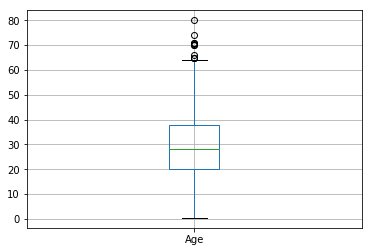

In [23]:
%matplotlib inline

df[['Age']].boxplot();

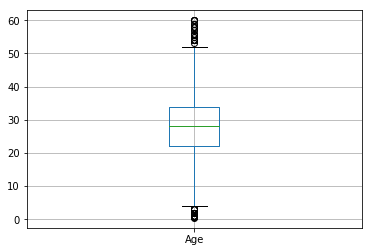

In [28]:
df = df[df.Age < df.Age.quantile(.99)]

df[['Age']].boxplot();

In [24]:
'{:.0%} passengers with unknown age'.format(df['Age'].isnull().mean())

'20% passengers with unknown age'

In [25]:
df['Age'].fillna(df.Age.median(), inplace=True)

In [26]:
'{:.0%} passengers with unknown age'.format(df['Age'].isnull().mean())

'0% passengers with unknown age'

In [29]:
df['Age'] = pandas.cut(df['Age'],
                       bins=[df.Age.min(), 18, 40, df.Age.max()],
                       labels=['Underage', 'Young', 'Experienced'])
df['Age'].head()

0    Young
1    Young
2    Young
3    Young
4    Young
Name: Age, dtype: category
Categories (3, object): [Underage < Young < Experienced]

In [30]:
df['Sex'] = df['Sex'].replace({'female': 1, 'male': 0})

df = df.pivot_table(values='Sex', columns='Pclass', index='Age', aggfunc='mean')
df

Pclass,1,2,3
Age,,,
Underage,0.687500,0.482759,0.462366
Young,0.459677,0.404959,0.257703
Experienced,0.387097,0.419355,0.228571


In [31]:
df = df.rename_axis('', axis='columns')
df = df.rename('Class {}'.format, axis='columns')
df.style.format('{:.2%}')

,Class 1,Class 2,Class 3
Age,,,
Underage,68.75%,48.28%,46.24%
Young,45.97%,40.50%,25.77%
Experienced,38.71%,41.94%,22.86%


## So, what's going on?

### Deprecations

- `.ix` method
 - Use `.loc` and `.iloc` instead

- Deprecation of `Panel` (3-dimensional `DataFrame`)
 - Use `DataFrame` with multi-index, or `x-array` package instead

- `SparseDataFrame`
 - TBC

### Deprecations

- `inplace=True` in `Series` and `DataFrame` methods
 - TBC

In [2]:
import pandas

df = pandas.read_csv('data/titanic.csv.gz')

df = df[df.Age < df.Age.quantile(.99)]

df['Age'].fillna(df.Age.median(), inplace=True)  # <- Using inplace

df['Age'] = pandas.cut(df['Age'],
                       bins=[df.Age.min(), 18, 40, df.Age.max()],
                       labels=['Underage', 'Young', 'Experienced'])

df['Sex'] = df['Sex'].replace({'female': 1, 'male': 0})

df = df.pivot_table(values='Sex', columns='Pclass', index='Age', aggfunc='mean')

df = df.rename_axis('', axis='columns')

df = df.rename('Class {}'.format, axis='columns')

df.style.format('{:.2%}')

,Class 1,Class 2,Class 3
Age,,,
Underage,68.75%,48.28%,46.24%
Young,51.06%,42.73%,22.62%
Experienced,36.11%,40.62%,23.68%


In [1]:
import pandas

(pandas.read_csv('data/titanic.csv.gz')
       .query('Age < Age.quantile(.99)')
       .assign(Sex=lambda df: df['Sex'].replace({'female': 1, 'male': 0}),
               Age=lambda df: pandas.cut(df['Age'].fillna(df.Age.median()),
                                         bins=[df.Age.min(), 18, 40, df.Age.max()],
                                         labels=['Underage', 'Young', 'Experienced']))
       .pivot_table(values='Sex', columns='Pclass', index='Age', aggfunc='mean')
       .rename_axis('', axis='columns')
       .rename('Class {}'.format, axis='columns')
       .style.format('{:.2%}'))

,Class 1,Class 2,Class 3
Age,,,
Underage,68.75%,48.28%,46.24%
Young,51.06%,42.73%,22.62%
Experienced,36.11%,40.62%,23.68%


### TODO: explain well memory copies and lazy operations

- This syntax should avoid unnecesary memory copies
- May be in the long term operations could be lazy?

## Dropping Python 2 support

- In January 2019 (yes, in 4.5 months)
 - Not only pandas, also numpy, matplotlib and others

## Some Python 3 features

Old:
```python
samples = 100000000
```

New:
```python
samples = 100_000_000
```

## Some Python 3 features

Old:
```python
print('samples: %s' % samples)
print('samples: {samples}'.format(samples=samples))
```

New:
```python
print(f'samples: {samples}')
```

## Some Python 3 features

```python
data = 'My hovercraft is full of eels.'.split()
```

Old:
```python
first, second, last = data[0], data[1], data[-1]
```

New:
```python
first, second, *discard, last = data
```

## Cost of supporting Python 2

Supporting last version only:
```python
def length(value):
    if isinstance(value, str):
        return len(value)
```

Supporting Python 2:
```python
def length(value):
    if isinstance(value, compat.string_types):
        return compat.strlen(value)
```

## Cost of supporting Python 2

Supporting last version only:
```python
def sorted_apply(func, items):
    return {x: func(x) for x in items}
```

Supporting Python 2:
```python
def sorted_apply(func, items):
    if compat.PY36:
        return {x: func(x) for x in items}
    else:
        result = collections.OrderedDict()
        for x in items:
            result[x] = func(x)
        return result
```

## Dropping Python 2 support

- In January 2019 (yes, in 4.5 months)
 - Not only pandas, also numpy, matplotlib and others

## Extension arrays

In [3]:
import numpy
import pandas

s = pandas.Series([1, 2, 3], dtype=numpy.uint8)

s

0    1
1    2
2    3
dtype: uint8

### Categories

In [10]:
s = pandas.Series(['dog', 'cat', 'dog'], dtype='category')

s

0    dog
1    cat
2    dog
dtype: category
Categories (2, object): [cat, dog]

In [11]:
s.cat.codes

0    1
1    0
2    1
dtype: int8

### Cyberpandas

In [5]:
import cyberpandas

arr = cyberpandas.IPArray(['127.0.0.1', '255.255.255.0'])

s = pandas.Series(arr)

s

0        127.0.0.1
1    255.255.255.0
dtype: ip

### Geopandas

In [1]:
import geopandas
from shapely.geometry import Point

geometry = geopandas.GeoSeries([Point(51.500772, -0.124621),
                                Point(48.858251, 2.294413)])

cities = geopandas.GeoDataFrame([('Big Ben', 'London'),
                                 ('Tour Eiffel', 'Paris')],
                                columns=('attraction', 'city'),
                                geometry=geometry)

cities.dtypes

attraction    object
city          object
geometry      object
dtype: object

### Fletcher

In [12]:
spam_list = [random.choice(['spam', 'spam,', 'spam!'])
             for i in range(10_000_000)]

spam_list[:10]

['spam',
 'spam',
 'spam',
 'spam,',
 'spam',
 'spam!',
 'spam!',
 'spam!',
 'spam',
 'spam!']

In [13]:
import pandas

s = pandas.Series(spam_list)

s.str.endswith('!').mean()

0.333175

In [21]:
print('%.2f Mb' % (s.memory_usage(deep=True) / 1024 / 1024))

84.65 Mb


In [14]:
%timeit s.str.endswith('!').mean()

4.71 s ± 350 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
import fletcher

spam_fletcher = fletcher.FletcherArray(spam_list)

s = pandas.Series(spam_fletcher)
s.head()

0     spam
1     spam
2     spam
3    spam,
4     spam
dtype: fletcher[string]

In [24]:
print('%.2f Mb' % (s.memory_usage(deep=True) / 1024 / 1024))

84.65 Mb


In [26]:
%timeit s.text.endswith('!').mean()

3.15 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1]:
import fletcher

fletcher.FletcherArray(range(3))

AttributeError: 'FletcherArray' object has no attribute '__name__'

In [2]:
fletcher.FletcherArray(None)

AttributeError: 'FletcherArray' object has no attribute '__name__'